In [2]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, Math

from qiskit import IBMQ
import qiskit.pulse as pulse
import qiskit.pulse.pulse_lib as pulse_lib
from qiskit.compiler import assemble

## Loading system

In [3]:
IBMQ.load_accounts()
backend_name = 'ibmq_poughkeepsie'
backend = IBMQ.get_backend(backend_name)

In [4]:
config = backend.configuration()
defaults = backend.defaults()

system = pulse.PulseChannelSpec.from_backend(backend)

In [5]:
display(Math(config.hamiltonian['h_latex']))

<IPython.core.display.Math object>

## CR rabi

In [19]:
# experimental configs
exps = 64
shots = 512

# qubit ids
target = 10
control = 15

# control channel
uchannel = 36

# measurement pulses
meas_amp = 0.025
meas_samples = 1200
meas_sigma = 4
meas_risefall = 25

# CR rabi pulse
cr_amps = np.linspace(0, 0.1, exps)
cr_samples = 300
cr_sigma = 5
cr_risefall = 15

# scaling factor
scale_factor = 1e-10

Check frequencies of qubit: $f_{c} > f_{t}$

In [20]:
defaults.qubit_freq_est[target]

4.719692555374837

In [21]:
defaults.qubit_freq_est[control]

4.806466890845457

Measurement instruction

In [22]:
meas_pulse = pulse_lib.gaussian_square(duration=meas_samples,
                                       amp=meas_amp,
                                       sigma=meas_sigma,
                                       risefall=meas_risefall,
                                       name='meas_pulse')
acq_command = pulse.Acquire(duration=meas_samples)

measure = meas_pulse(system.measures[target]) | acq_command(system.acquires, system.memoryslots)

Get $\pi$-pulse of control qubit:

In [23]:
cmd_def = pulse.CmdDef.from_defaults(defaults.cmd_def, defaults.pulse_library)

In [24]:
control_xgate = cmd_def.get('u3', qubits=control, P1=np.pi, P2=0, P3=np.pi)

CR Rabi schedule

In [25]:
schedules = []

for c_states in range(2):
    for ii, cr_amp in enumerate(cr_amps):
        cr_pulse = pulse_lib.gaussian_square(duration=cr_samples,
                                             amp=cr_amp,
                                             sigma=cr_sigma,
                                             risefall=cr_risefall,
                                             name='cr_pulse%d' % ii)

        schedule = pulse.Schedule(name='CR Rabi experiment at drive amp = %s (control state = %s)' 
                                  % (cr_amp, c_states))
        
        if c_states:
            schedule += control_xgate
        schedule += cr_pulse(system.controls[uchannel]) << control_xgate.duration
        schedule += measure << schedule.duration

        schedules.append(schedule)

A schedule with control qubit = 0

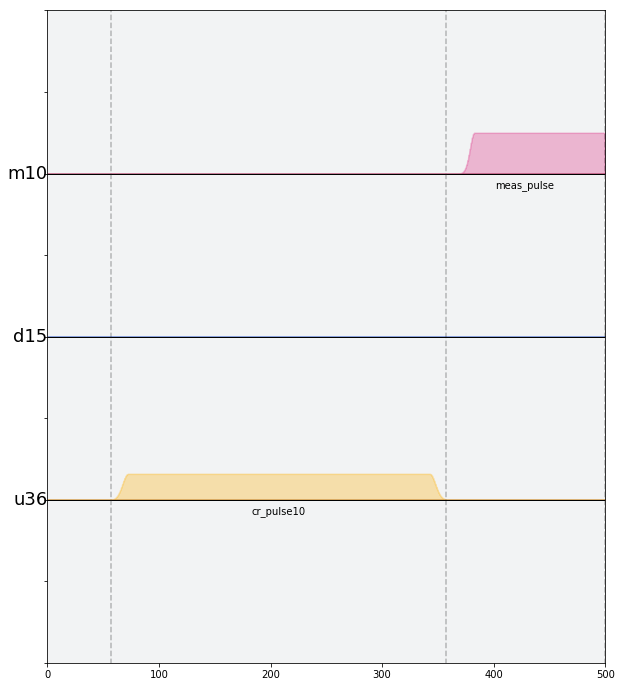

In [26]:
channels = [system.drives[control], system.controls[uchannel], system.measures[target]]
schedules[10].draw(channels_to_plot=channels, scaling=20, plot_range=(0, 500), label=True)

A schedule with control qubit = 1

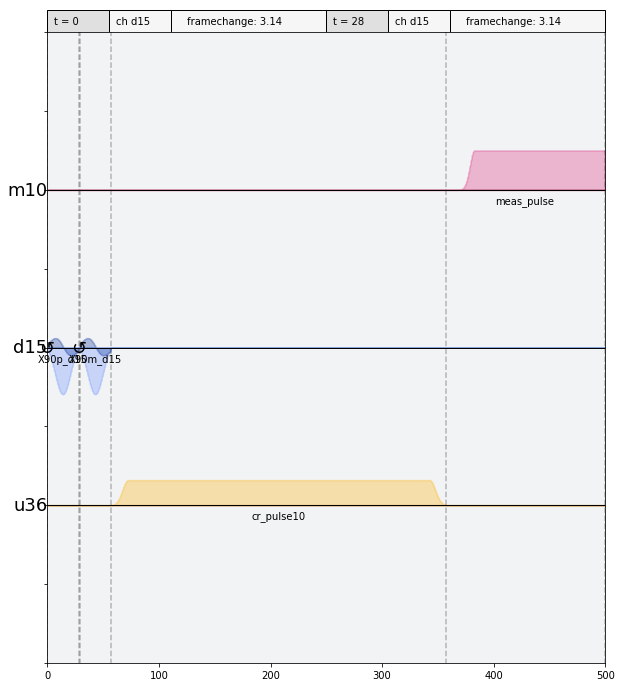

In [27]:
channels = [system.drives[control], system.controls[uchannel], system.measures[target]]
schedules[exps+10].draw(channels_to_plot=channels, scaling=20, plot_range=(0, 500), label=True)

In [15]:
cr_rabi_qobj = assemble(schedules, backend, meas_level=1, meas_return='avg', shots=shots)

In [16]:
job = backend.run(cr_rabi_qobj)

/home/knzwnao/venv/qiskit-dev/lib/python3.6/site-packages/qiskit/providers/ibmq/ibmqjob.py:139: DeprecationWarning: The as_dict() method is deprecated, use to_dict().
  self._qobj_payload = qobj.as_dict()


In [17]:
job.job_id()

'5d1c48ef3467000018f14388'

In [18]:
job.status()

<JobStatus.RUNNING: 'job is actively running'>